In [4]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"baishalidsu","key":"37fda11d3db7627db7a8efb4a6a60dce"}'}

In [2]:
!pip install -U -q kaggle==1.5.8

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!ls ~/.kaggle

kaggle.json


In [7]:
!chmod 600 /root/.kaggle/kaggle.json #run this command to ensure your Kaggle API token is secure on colab

In [10]:
%%capture
!wget https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/Caltech_256_Train.zip

!unzip "Caltech_256_Train.zip"

In [11]:
import itertools
import math
import time
import matplotlib.pyplot as plt
from IPython import display

# Pytorch Packages
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [12]:
# Normalize with mean and st.dev
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.4839, 0.4528, 0.3962), (0.2702, 0.2655, 0.2745))])

Loading the train file

In [13]:
# Loading the train set file
train_data_folder = "/content/Caltech_256_Train" # Train directory for loading images
train_data = datasets.ImageFolder(root=train_data_folder, transform=transform)

In [14]:
# Initializing batch size
batch_size = 256

# Loading the train dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [15]:
# Generate a batches of images and labels
train_images, train_labels = next(iter(train_loader))
train_images.shape, train_labels.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

Defining the discriminator Model

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(150528, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),# final layeris 256 output layer is 1
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x.view(x.size(0), 150528))
        out = out.view(out.size(0), -1)
        return out

Defining the generator model

In [17]:
class Generator(nn.Module):# latent dimension is a reduced dimension but having all relevent information
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),# the noise is of 100 -d and the generated image is having dimension of 785-d
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True), # The features of teh image can be changed with the change in noise, 2 dimensions of noise may be having effect on the colour of the image
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 150528),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

Initializing CUDA

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 2.0.1+cu118 CUDA: True


Creating the generator and Discriminator Instance

In [19]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

Defining the Optimizer function

In [20]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

Training the discriminator function

In [21]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):

    # Train on real images
    # Reset gradients
    discriminator.zero_grad()# setting all grad to 0, reseting everything to 0
    prediction_real = discriminator(images)

    # Comparing original images
    real_loss = criterion(prediction_real, real_labels)

    # Train on fake images
    prediction_fake = discriminator(fake_images)

    # Comparing fake images
    # Calculate error and backpropagate
    fake_loss = criterion(prediction_fake, fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()

    # Update weights with gradients
    d_optimizer.step()
    return d_loss, prediction_real, prediction_fake

Training the generator Function

In [22]:
def train_generator(generator, fake_images, real_labels):# discriminator should not be touched during discriminator training and vice versa
    # Train Generator
    # Reset gradients
    generator.zero_grad()

    # Sample noise and generate fake data
    discriminator_outputs = discriminator(fake_images)# for every bacth the discriminator will be trained and then the generator will be trained

    # Calculate error and backpropagate
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()

    # Update weights with gradients
    g_optimizer.step()

    # Return error
    return g_loss

Generate samples for testing

In [23]:
# Draw samples from the input distribution to inspect the generation on training
num_test_samples = 16
test_noise = torch.randn(num_test_samples, 100).to(device)# this 100 will go as an input to the neural network model

Lets start training the GAN

In [24]:
!mkdir results

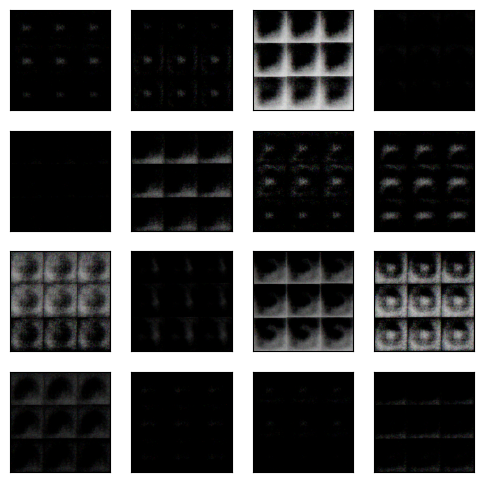

Epoch [60/60], Step[80/83], d_loss: 0.3853, g_loss: 2.8709, D(x): 0.93, D(G(z)): 0.15


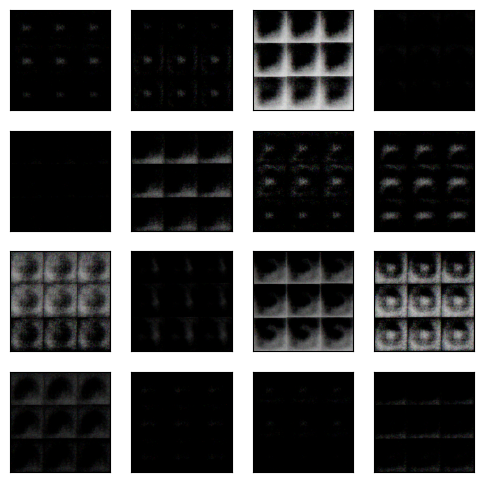

In [29]:
# Create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Set number of epochs and initialize figure counter# under every epoch there are minibatches of 100 that are getting trained
num_epochs = 60    # Increase the no of epochs to see the better quality images
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):# train loader will return images and class

        images = images.to(device)
        real_labels = torch.ones(images.size(0), 1).to(device)

        # Sample from generator
        # Generate fake images by passing the random noise vector to the generator
        noise = torch.randn(images.size(0), 100).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # Train the discriminator
        d_loss, d_pred_real, d_pred_fake = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)

        # Sample again from the generator
        noise = torch.randn(images.size(0), 100).to(device)
        fake_images = generator(noise)

        # Train the generator
        g_loss = train_generator(generator, fake_images, real_labels)

        if (n+1) % 10 == 0:
            test_images = generator(test_noise)

            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(224, 224,3))
            display.clear_output(wait=True)
            display.display(plt.gcf())

            plt.savefig('results/mnist-gan-%03d.png')
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, '
                  'D(x): %.2f, D(G(z)): %.2f'
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
                    d_pred_real.data.mean(), d_pred_fake.data.mean()))
fig.show()